In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from pprint import pprint

In [2]:
import sys
import warnings
warnings.filterwarnings('ignore')
import tqdm
from tqdm import tqdm

from sklearn.metrics import mean_absolute_error, mean_squared_error

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from scipy.optimize import minimize

import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv("train.csv", parse_dates=['DATE'])

In [ ]:
df.head()

In [92]:
train.CLIENT_OUT[train.CLIENT_OUT < 0] = 0
min(train.CLIENT_OUT), max(train.CLIENT_OUT)

(0, 5752900)

In [34]:
def ATM_n(n):
    df = train.loc[train['ATM_ID']==n]
    df = df.loc[:, df.columns != 'ATM_ID']
    return df

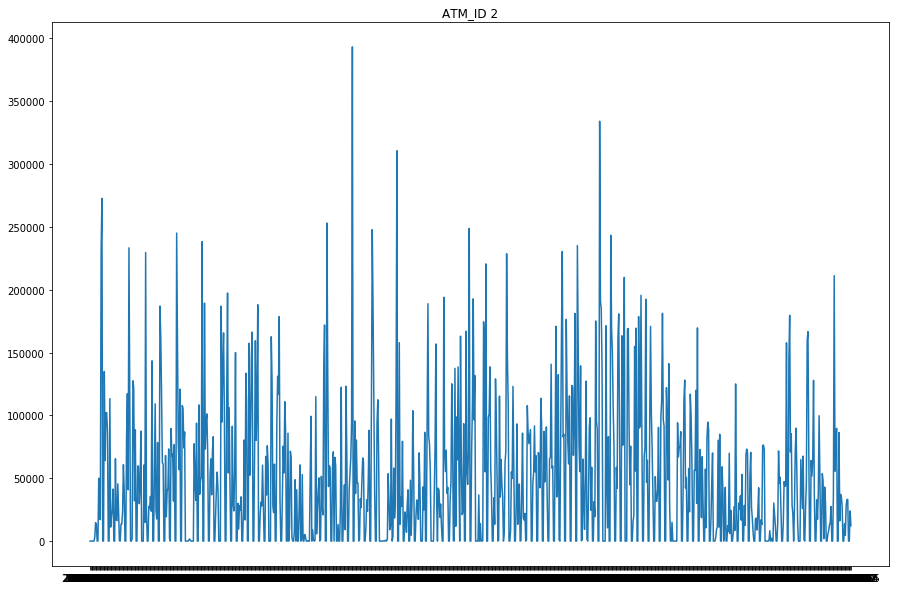

In [44]:
ids = [2]
for id in ids:
    plt.figure(figsize=(15,10))
    plt.title('ATM_ID {0}'.format(id))
    plt.plot(train[train.ATM_ID == id].DATE, train[train.ATM_ID==id].CLIENT_OUT)
    plt.show()

In [124]:
df['week_day'] = df.DATE.dt.dayofweek
df['num_week'] = df.DATE.dt.week
df['year'] = df.DATE.dt.year
df['day_of_year'] = df.DATE.dt.dayofyear
    
condition_holiday = (
    (df.DATE.dt.month == 1) & ((df.DATE.dt.day >= 1) & (df.DATE.dt.day <= 8)) # winter
    | (df.DATE.dt.month == 2) & ((df.DATE.dt.day >= 21) & (df.DATE.dt.day <= 25)) # around 23 feb
    | (df.DATE.dt.month == 3) & ((df.DATE.dt.day >= 6) & (df.DATE.dt.day <= 10)) # around 8 mar
    | (df.DATE.dt.month == 5) & ((df.DATE.dt.day >= 1) & (df.DATE.dt.day <= 10)) # may
    | (df.DATE.dt.month == 6) & ((df.DATE.dt.day >= 10) & (df.DATE.dt.day <= 14)) # around 12 june
    | (df.DATE.dt.month == 11) & ((df.DATE.dt.day >= 2) & (df.DATE.dt.day <= 6)) # around 4 nov
)
    
df['holiday_dummy'] = condition_holiday + 0

## Данные

In [3]:
import pickle
df = pickle.load(open("df", "rb"))

In [13]:
from score_submission import scorer, score_series

In [5]:
from functions.date_split import split_month_test
train_df, test_df = split_month_test(df, 30, 100) # 30 days test, 100 days train

In [6]:
X_train, y_train = train_df[df.columns.difference(['DATE', 'CLIENT_OUT'])], train_df.CLIENT_OUT
X_test, y_test = test_df[df.columns.difference(['DATE', 'CLIENT_OUT'])], test_df.CLIENT_OUT

## Предсказание

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

In [8]:
# Линейная регрессия с Lasso и Ridge регуляризацией

In [33]:
alphas = [1e-8, 1e-5, 1e-4, 1e-3, 1e-2, 1]
metrics = {}
for alpha in tqdm(alphas):
    model = Lasso(alpha=alpha, normalize=True)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    pred_df = test_df.copy()
    pred_df.CLIENT_OUT = y_pred
    metrics['Lasso with alpha = {}'.format(alpha)] = scorer(test_df, pred_df)

100%|██████████| 6/6 [00:21<00:00,  3.62s/it]


In [34]:
for alpha in alphas:
    model = Ridge(alpha=alpha, normalize=True)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    pred_df = test_df.copy()
    pred_df.CLIENT_OUT = y_pred
    metrics['Ridge with alpha = {}'.format(alpha)] = scorer(test_df, pred_df)

In [32]:
min(metrics), metrics[min(metrics)]

('Lasso with alpha = 0.0001', 0.06613862598769693)

In [169]:
# Решающий лес

In [35]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf, 
                               param_distributions = random_grid, 
                               n_iter = 100, 
                               cv = 3, 
                               verbose=2, 
                               random_state=42, 
                               n_jobs = 40)
rf_random.fit(X_train, y_train)
print(rf_random.best_params_)
rf_clf = rf_random.best_estimator_

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=True 
[CV] n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=True 
[CV] n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=True 
[CV] n_estimators=2000, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=10, bootstrap=True 
[CV] n_estimators=2000, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=10, bootstrap=True 
[CV] n_estimators=2000, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=10, bootstrap=True 
[CV] n_estimators=1200, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=10, bootstrap=False 
[CV] n_estimators=1200, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=10, bootstrap=False 
[CV] n_estimators=1200, mi

[CV]  n_estimators=1200, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=10, bootstrap=False, total= 1.8min
[CV] n_estimators=1400, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=80, bootstrap=True 
[CV] n_estimators=1400, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=80, bootstrap=True 
[CV]  n_estimators=1200, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=10, bootstrap=False, total= 1.9min
[CV] n_estimators=1800, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=None, bootstrap=True 
[CV]  n_estimators=1600, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=10, bootstrap=True, total= 1.9min
[CV] n_estimators=1800, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=None, bootstrap=True 
[CV]  n_estimators=1600, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=10, bootstrap=True, total= 1.9min
[CV] n_estimators=1800

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  4.0min


[CV]  n_estimators=800, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=90, bootstrap=False, total= 3.8min
[CV] n_estimators=800, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=100, bootstrap=False 
[CV]  n_estimators=800, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=90, bootstrap=False, total= 3.9min
[CV] n_estimators=800, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=50, bootstrap=True 
[CV]  n_estimators=1000, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=100, bootstrap=False, total= 4.3min
[CV] n_estimators=800, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=50, bootstrap=True 
[CV]  n_estimators=400, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=None, bootstrap=False, total= 2.2min
[CV] n_estimators=800, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=50, bootstrap=True 
[CV]  n_estimators=400,

[CV]  n_estimators=800, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=20, bootstrap=False, total= 2.2min
[CV] n_estimators=200, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=90, bootstrap=False 
[CV]  n_estimators=1600, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=70, bootstrap=False, total= 7.0min
[CV] n_estimators=200, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=90, bootstrap=False 
[CV]  n_estimators=200, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=10, bootstrap=True, total=  56.7s
[CV] n_estimators=200, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=90, bootstrap=False 
[CV]  n_estimators=600, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=70, bootstrap=False, total= 7.4min
[CV] n_estimators=1000, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=110, bootstrap=True 
[CV]  n_estimators=800, mi

[CV]  n_estimators=200, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=90, bootstrap=False, total= 2.5min
[CV] n_estimators=600, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=60, bootstrap=False 
[CV]  n_estimators=200, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=90, bootstrap=False, total= 2.5min
[CV] n_estimators=600, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=60, bootstrap=False 
[CV]  n_estimators=1000, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=60, bootstrap=True, total= 3.7min
[CV] n_estimators=1600, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=10, bootstrap=True 
[CV]  n_estimators=1000, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=60, bootstrap=True, total= 3.8min
[CV] n_estimators=1600, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=10, bootstrap=True 
[CV]  n_estimators=1600, min

[CV]  n_estimators=1400, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=80, bootstrap=True, total= 3.0min
[CV] n_estimators=1800, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=10, bootstrap=False 
[CV]  n_estimators=1400, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=None, bootstrap=False, total= 5.1min
[CV] n_estimators=1400, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=70, bootstrap=True 
[CV]  n_estimators=1400, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=80, bootstrap=True, total= 3.1min
[CV] n_estimators=1400, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=70, bootstrap=True 
[CV]  n_estimators=1400, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=None, bootstrap=False, total= 5.3min
[CV] n_estimators=1400, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=70, bootstrap=True 
[CV]  n_estimators=

[CV] n_estimators=2000, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=100, bootstrap=True 
[CV]  n_estimators=800, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=20, bootstrap=False, total= 2.2min
[CV] n_estimators=1000, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=10, bootstrap=True 
[CV]  n_estimators=400, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=90, bootstrap=False, total= 1.3min
[CV] n_estimators=1000, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=10, bootstrap=True 
[CV]  n_estimators=400, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=90, bootstrap=False, total= 1.5min
[CV] n_estimators=1000, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=10, bootstrap=True 
[CV]  n_estimators=400, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=90, bootstrap=False, total= 1.4min
[CV] n_estimators=200, m

[CV] n_estimators=1000, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=10, bootstrap=True 
[CV]  n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=90, bootstrap=False, total= 5.7min
[CV] n_estimators=1000, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=10, bootstrap=True 
[CV]  n_estimators=1800, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=10, bootstrap=False, total=10.7min
[CV] n_estimators=1000, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=10, bootstrap=True 
[CV]  n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=100, bootstrap=True, total=  57.5s
[CV] n_estimators=600, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=110, bootstrap=True 
[CV]  n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=100, bootstrap=True, total= 1.2min
[CV] n_estimators=600, 

[CV]  n_estimators=2000, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=90, bootstrap=True, total=19.2min
[CV]  n_estimators=1200, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=None, bootstrap=False, total=14.3min
[CV]  n_estimators=1800, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=20, bootstrap=False, total=18.7min
[CV]  n_estimators=600, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=110, bootstrap=True, total= 1.5min
[CV]  n_estimators=1800, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=80, bootstrap=True, total=16.0min
[CV]  n_estimators=1400, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=70, bootstrap=True, total=12.3min
[CV]  n_estimators=600, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=110, bootstrap=True, total= 1.6min
[CV]  n_estimators=2000, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_d

In [37]:
rf_random.best_score_

0.6566244016726913

In [42]:
model = rf_clf
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
pred_df = test_df.copy()
pred_df.CLIENT_OUT = y_pred
scorer(test_df, pred_df)

0.37716315878868484

In [47]:
with open("rf_clf.pickle", 'wb') as rf_file:
    pickle.dump(rf_clf, rf_file)

In [40]:
!conda install -c conda-forge xgboost

Solving environment: done

## Package Plan ##

  environment location: /home/progiv/anaconda3

  added / updated specs: 
    - xgboost


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2018.1.18          |           py36_0         143 KB  conda-forge
    xgboost-0.7.post4          |           py36_0         1.4 MB  conda-forge
    conda-4.3.34               |           py36_0         514 KB  conda-forge
    openssl-1.0.2n             |                0         3.5 MB  conda-forge
    ca-certificates-2018.1.18  |                0         140 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         5.7 MB

The following NEW packages will be INSTALLED:

    xgboost:         0.7.post4-py36_0      conda-forge

The following packages will be UPDATED:

    ca-certificates: 2017.08.26-h1d4fec5_0            

In [38]:
import xgboost as xgb

parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['reg:linear'],
              'learning_rate': [.03, 0.05, .07], #so called `eta` value
              'max_depth': range(3,10,2),
              'min_child_weight': range(1,6,2),
              'silent': [1],
              'subsample': [i/10.0 for i in range(6,10)],
              'colsample_bytree': [i/10.0 for i in range(6,10)],
              'n_estimators': [500]}

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        cv = 3,
                        n_jobs = 40,
                        verbose=True)

xgb_grid.fit(X_train, y_train)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)
xgb_clf = xgb_grid.best_estimator_

ModuleNotFoundError: No module named 'xgboost'

In [ ]:
model = xgb_clf
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
pred_df = test_df.copy()
pred_df.CLIENT_OUT = y_pred
scorer(test_df, pred_df)

In [163]:
def prediction(train, test):
    X_train, y_train, X_test = train.loc[:, train.columns != 'ATM_ID'], train['ATM_ID'], test
    model.fit(X_train, y_train)
    y_pred = lr.predict(X_test)
    return y_pred